# PROJECT TITLE : PM_980 DATASET FOR SIGNAL CLASSIFICATION

## Name Surname: Gökhan Ergül Student ID: 211805060

In [1]:
from datetime import datetime
print("Date:", datetime.today().strftime('%Y-%m-%d'))

Date: 2025-06-09


In [2]:
# Required libraries
import os
import re
import time
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.fft import rfft, rfftfreq

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import classification_report

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Feature Engineering
and loading the dataset

#### important note: As you can see, we handle all the data at once, but **we do not mix the csv files**, thus preventing confusion.

In [3]:
SAMPLE_LENGTH = 90  # Simulated 1-second windows
data_dir = "PM980" 
feature_data = []

for filename in os.listdir(data_dir):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_dir, filename)
        df = pd.read_csv(file_path)

        # Metadata from filename
        parts = filename.split("_")
        label = parts[2]
        condition = parts[3]
        noise = parts[4]

        total_rows = len(df)
        num_chunks = total_rows // SAMPLE_LENGTH # As you can see, we are not mixing csv files here.

        for i in range(num_chunks):
            chunk = df.iloc[i*SAMPLE_LENGTH : (i+1)*SAMPLE_LENGTH]

            features = {}
            for col in ['Acceleration X', 'Acceleration Y', 'Acceleration Z', 
                        'Gyro X', 'Gyro Y', 'Gyro Z', 'Voice', 'Temperature']:
                features[col + '_mean'] = chunk[col].mean()
                features[col + '_std'] = chunk[col].std()
                features[col + '_max'] = chunk[col].max()
                features[col + '_min'] = chunk[col].min()
                features[col + '_range'] = chunk[col].max() - chunk[col].min()

            # Label info
            features['Speed'] = df['Speed'].values[0]
            features['condition'] = condition
            features['noise'] = noise
            features['label'] = label

            feature_data.append(features)

# Final DataFrame ready for ML
feature_df = pd.DataFrame(feature_data)


In [4]:
feature_df.head()

,Acceleration X_mean,Acceleration X_std,Acceleration X_max,Acceleration X_min,Acceleration X_range,Acceleration Y_mean,Acceleration Y_std,Acceleration Y_max,Acceleration Y_min,Acceleration Y_range,...,Voice_range,Temperature_mean,Temperature_std,Temperature_max,Temperature_min,Temperature_range,Speed,condition,noise,label
0,-0.367667,1.821421,4.45,-6.03,10.48,-0.044444,4.143137,6.81,-6.57,13.38,...,2928.0,27.174556,0.010827,27.20,27.15,0.05,100.0,indoor,clear,healthynotchlong
1,-0.067222,1.350793,3.40,-2.92,6.32,0.166889,4.436007,6.78,-6.78,13.56,...,2928.0,27.169778,0.011315,27.19,27.15,0.04,100.0,indoor,clear,healthynotchlong
2,0.192000,1.250365,2.88,-2.79,5.67,-0.054667,4.535614,6.41,-6.76,13.17,...,2929.0,27.158000,0.012197,27.18,27.13,0.05,100.0,indoor,clear,healthynotchlong
3,-0.286222,1.059287,2.59,-2.35,4.94,0.022333,4.273304,6.76,-6.98,13.74,...,2928.0,28.374778,0.011439,28.40,28.35,0.05,100.0,indoor,noisy,healthynotchlong
4,-0.309889,1.007390,1.91,-2.08,3.99,0.022111,4.205900,5.97,-5.74,11.71,...,2928.0,28.366778,0.012163,28.40,28.34,0.06,100.0,indoor,noisy,healthynotchlong


In [5]:
df = feature_df.copy()

fixing the labels:

In [6]:
df['label'].unique()

array(['healthynotchlong', 'healthynotchshort', 'healthyscracth',
       'healthysinglecutlong', 'healthysinglecutshort',
       'healthytwocutlong', 'healthytwocutshort', 'healthywarped',
       'notchlong', 'notchshort', 'scracth', 'singlecutlong',
       'singlecutshort', 'twocutlong', 'twocutshort', 'warped'],
      dtype=object)

If a label contains healthy word turn it to healthy 

In [7]:
df.loc[df['label'].str.contains('healthy',na=False), 'label']='healthy'

In [8]:
columns = df['label'].unique()

checking the null values:

In [9]:
df.isna().sum()
#df.isna().sum().sum()
#you can see all columns

Acceleration X_mean     0
Acceleration X_std      0
Acceleration X_max      0
Acceleration X_min      0
Acceleration X_range    0
Acceleration Y_mean     0
Acceleration Y_std      0
Acceleration Y_max      0
Acceleration Y_min      0
Acceleration Y_range    0
Acceleration Z_mean     0
Acceleration Z_std      0
Acceleration Z_max      0
Acceleration Z_min      0
Acceleration Z_range    0
Gyro X_mean             0
Gyro X_std              0
Gyro X_max              0
Gyro X_min              0
Gyro X_range            0
Gyro Y_mean             0
Gyro Y_std              0
Gyro Y_max              0
Gyro Y_min              0
Gyro Y_range            0
Gyro Z_mean             0
Gyro Z_std              0
Gyro Z_max              0
Gyro Z_min              0
Gyro Z_range            0
Voice_mean              0
Voice_std               0
Voice_max               0
Voice_min               0
Voice_range             0
Temperature_mean        0
Temperature_std         0
Temperature_max         0
Temperature_

### saving dataset:

In [10]:
df.to_csv('pm980_final_dataset',index = False)

Loading the dataset:

In [11]:
df = pd.read_csv('pm980_final_dataset')

## Cross-Correlation & Important Features

### Cross-Correlation Map (Heatmap)

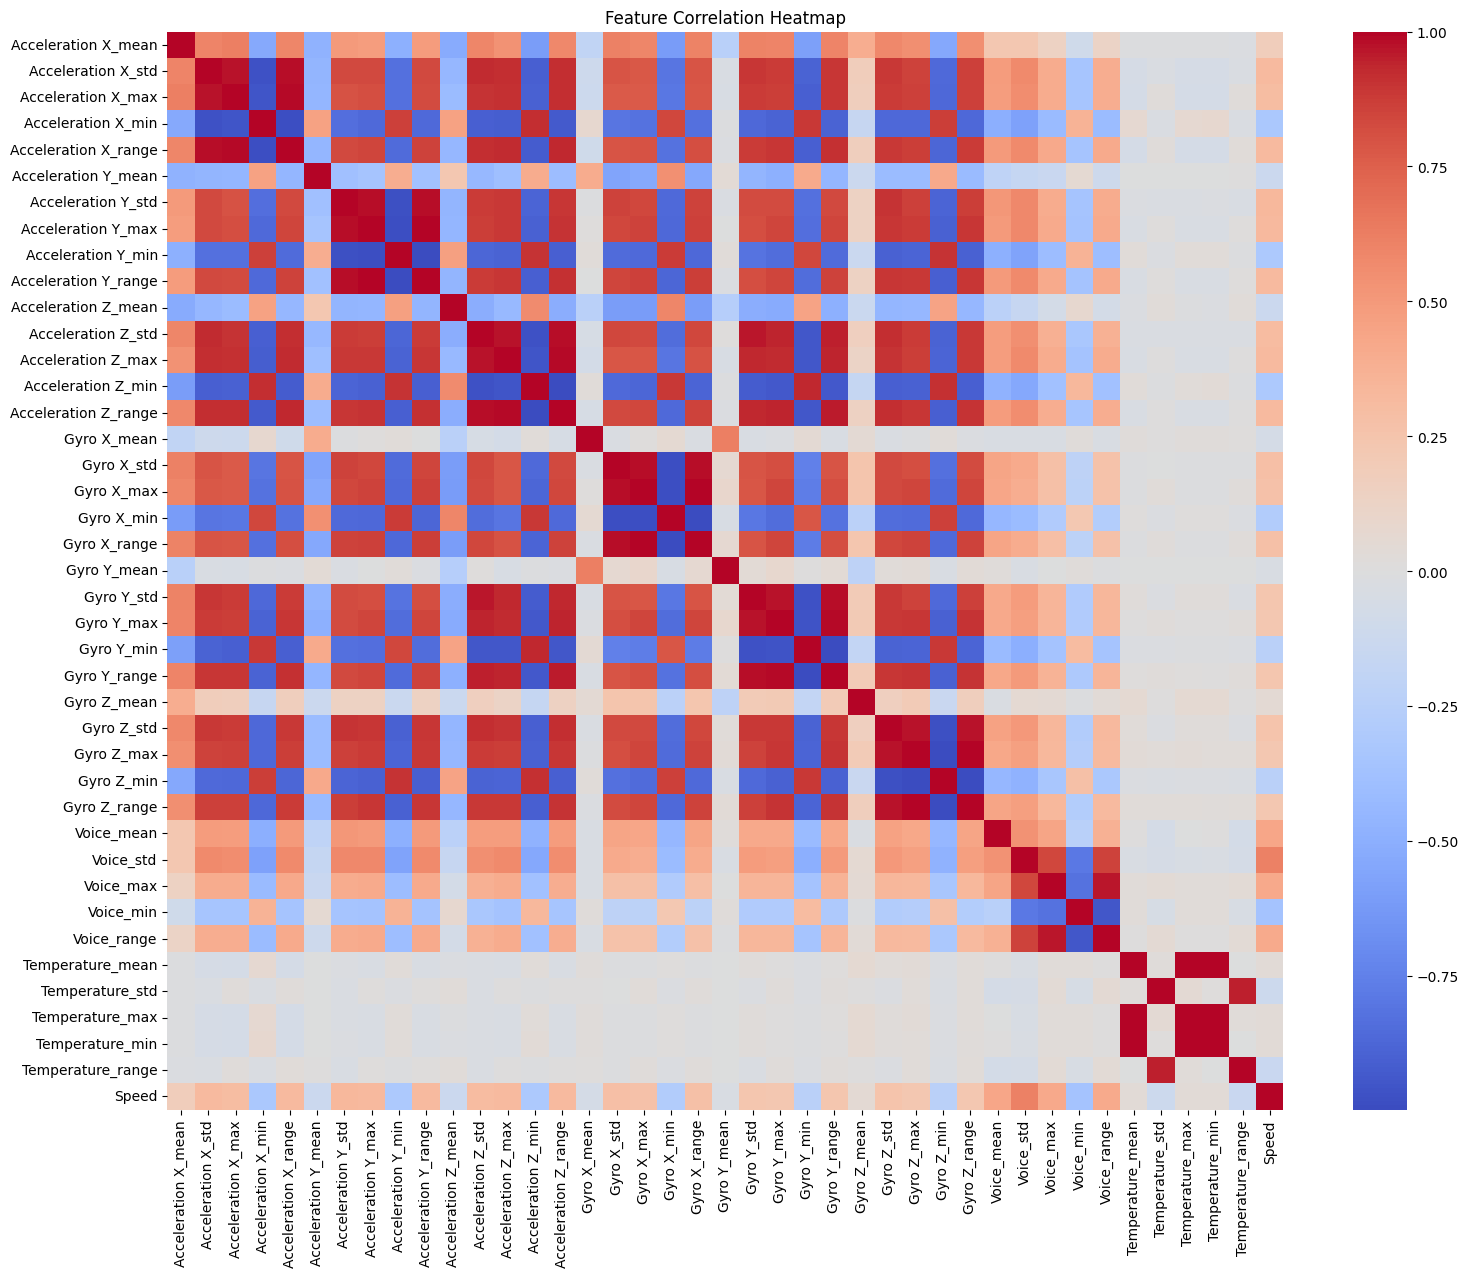

In [12]:
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
plt.figure(figsize=(18, 14))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

### Feature Importance using RandomForest

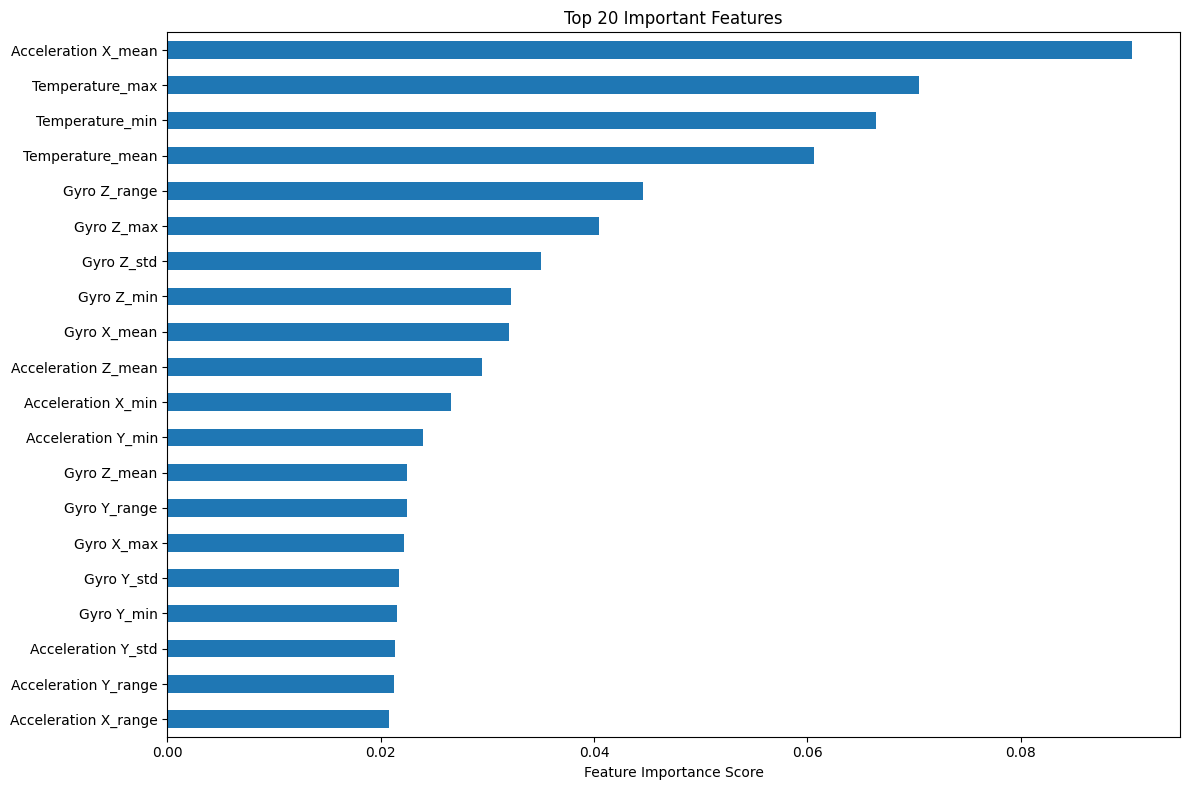

In [13]:
# Encode target label
le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])

# Drop non-numeric or ID-based features if any
X = df.drop(columns=['label', 'condition', 'noise'])  # adjust this if needed

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=13, stratify=y_encoded)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Recombine scaled data (optional, for full X_scaled)
X_scaled = pd.DataFrame(
    data = np.vstack([X_train_scaled, X_test_scaled]),
    columns = X.columns,
    index = X_train.index.tolist() + X_test.index.tolist()
).loc[X.index]  # fix the order according to original X


# Train model
model = RandomForestClassifier(random_state=13)
model.fit(X_scaled, y_encoded)

# Feature importance
importances = model.feature_importances_
feat_names = X.columns
feat_importances = pd.Series(importances, index=feat_names)

# Plot top 20 features
plt.figure(figsize=(12, 8))
feat_importances.nlargest(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Important Features")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()


## Explaining Inputs and Outputs

In [14]:
df.iloc[:,:-1]

,Acceleration X_mean,Acceleration X_std,Acceleration X_max,Acceleration X_min,Acceleration X_range,Acceleration Y_mean,Acceleration Y_std,Acceleration Y_max,Acceleration Y_min,Acceleration Y_range,...,Voice_min,Voice_range,Temperature_mean,Temperature_std,Temperature_max,Temperature_min,Temperature_range,Speed,condition,noise
0,-0.367667,1.821421,4.45,-6.03,10.48,-0.044444,4.143137,6.81,-6.57,13.38,...,0.0,2928.0,27.174556,0.010827,27.20,27.15,0.05,100.0,indoor,clear
1,-0.067222,1.350793,3.40,-2.92,6.32,0.166889,4.436007,6.78,-6.78,13.56,...,0.0,2928.0,27.169778,0.011315,27.19,27.15,0.04,100.0,indoor,clear
2,0.192000,1.250365,2.88,-2.79,5.67,-0.054667,4.535614,6.41,-6.76,13.17,...,0.0,2929.0,27.158000,0.012197,27.18,27.13,0.05,100.0,indoor,clear
3,-0.286222,1.059287,2.59,-2.35,4.94,0.022333,4.273304,6.76,-6.98,13.74,...,0.0,2928.0,28.374778,0.011439,28.40,28.35,0.05,100.0,indoor,noisy
4,-0.309889,1.007390,1.91,-2.08,3.99,0.022111,4.205900,5.97,-5.74,11.71,...,0.0,2928.0,28.366778,0.012163,28.40,28.34,0.06,100.0,indoor,noisy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2246,0.684333,1.596905,3.07,-2.28,5.35,0.642444,3.583635,4.86,-4.91,9.77,...,0.0,2928.0,27.950000,0.014764,27.98,27.92,0.06,90.0,indoor,noisy
2247,0.443889,1.861279,2.95,-2.58,5.53,1.291333,2.965239,4.81,-4.98,9.79,...,0.0,2928.0,27.944111,0.012711,27.97,27.92,0.05,90.0,indoor,noisy
2248,0.019444,1.788378,4.08,-3.49,7.57,-0.309222,3.792535,7.06,-7.07,14.13,...,0.0,2932.0,17.799889,0.012224,17.82,17.76,0.06,90.0,outdoor,noisy
2249,-0.076667,1.888333,3.87,-3.75,7.62,-0.018667,3.585899,5.52,-6.14,11.66,...,0.0,2928.0,17.783000,0.012128,17.82,17.75,0.07,90.0,outdoor,noisy


In [15]:
df['condition'] = df['condition'].map({'indoor': 0, 'outdoor': 1})
df['noise'] = df['noise'].map({'clear': 0, 'noisy': 1})

In [16]:
X = df.iloc[:,:-1]

X_final = np.concatenate(
    [X, df[['condition', 'noise']].values], 
    axis=1
)

In [17]:
# Define independent variables (X) and dependent variable (y)
X = df.iloc[:,:-1]  # All input features

y = df['label']                 # Target variable: fault class

feature_descriptions = {
    'Acceleration_X_mean': 'Mean acceleration along X-axis',
    'Acceleration_Y_mean': 'Mean acceleration along Y-axis',
    'Acceleration_Z_mean': 'Mean acceleration along Z-axis',
    'Gyro_X_mean': 'Mean gyroscopic signal along X-axis',
    'Gyro_Y_mean': 'Mean gyroscopic signal along Y-axis',
    'Gyro_Z_mean': 'Mean gyroscopic signal along Z-axis',
    'Temperature_max': 'Maximum temperature during sampling',
    'Speed_Range': 'Speed range midpoint (converted from string)',
    'Voice_range': 'Variation in voice sensor signal',
    'condition': 'Categorical environment feature (encoded)',
    'noise': 'Categorical noise level (encoded)'
}


### show inputs, output cross-correlation map

In [18]:
# Encode 'label' to numerical form
df_corr = df.copy()
df_corr['label_encoded'] = LabelEncoder().fit_transform(df_corr['label'])


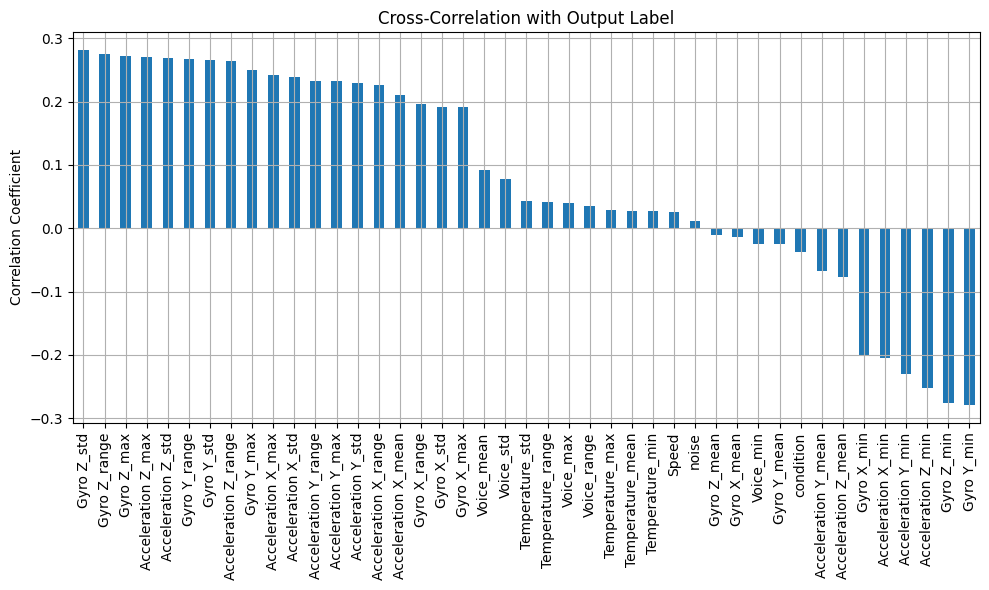

In [19]:
# Include all numerical columns (ignore object/categorical ones)
numeric_corr_df = df_corr.select_dtypes(include='number')

# Compute correlations between inputs and label
correlations = numeric_corr_df.corr()['label_encoded'].drop('label_encoded')

plt.figure(figsize=(10, 6))
correlations.sort_values(ascending=False).plot(kind='bar')
plt.title("Cross-Correlation with Output Label")
plt.ylabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\Gökhan ergül\AppData\Local\Temp\ipykernel_17856\3646735077.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


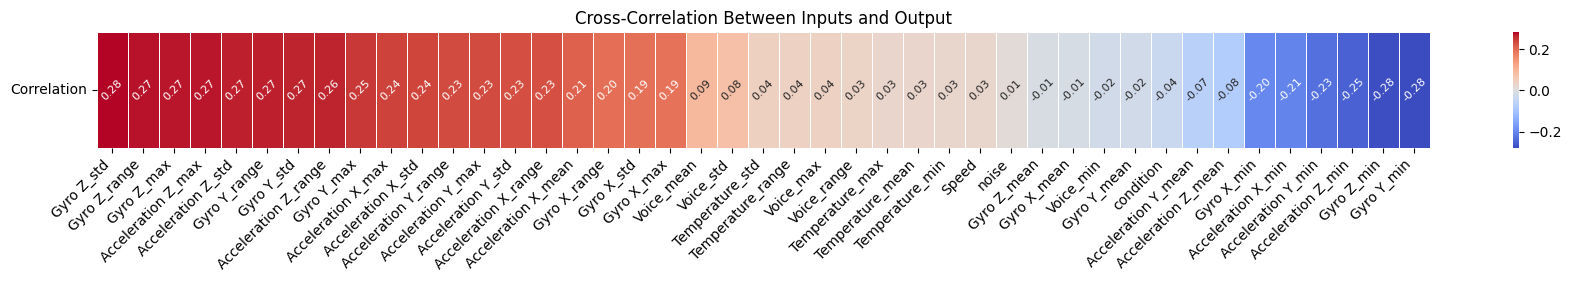

In [20]:
# Restructure data
correlation_df = correlations.sort_values(ascending=False).to_frame(name='Correlation')

plt.figure(figsize=(max(12, 0.5 * len(correlation_df)), 1.5))
sns.heatmap(
    correlation_df.T,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    cbar=True,
    linewidths=0.5,
    annot_kws={"rotation": 45, "fontsize": 8}
)
plt.title("Cross-Correlation Between Inputs and Output")
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Machine Learning, Evaluation & Model Selection

In [21]:
# Label encode classes
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Models
models = {
    "Random Forest": RandomForestClassifier(random_state=13),
    "Support Vector Classifier": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LightGBM": lgb.LGBMClassifier(random_state=13, verbose=-1)
}

# Stratified 10-fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=13)
results = {}
class_based_scores = {}

for model_name, model in models.items():
    accs, f1s, precs, recs, train_times, test_times = [], [], [], [], [], []
    class_reports = []
    all_y_true = []
    all_y_pred = []

    for train_index, test_index in skf.split(X, y_encoded):
        
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
            
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        X_train_num = X_train.iloc[:, :-2]
        X_test_num = X_test.iloc[:, :-2]
        X_train_cat = X_train[['condition', 'noise']].values
        X_test_cat = X_test[['condition', 'noise']].values

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_num)
        X_test_scaled = scaler.transform(X_test_num)

        X_train = np.concatenate([X_train_scaled, X_train_cat], axis=1)
        X_test = np.concatenate([X_test_scaled, X_test_cat], axis=1)

        # Train
        start_train = time.time()
        model.fit(X_train, y_train)
        train_times.append(time.time() - start_train)

        # Predict
        start_test = time.time()
        y_pred = model.predict(X_test)
        test_times.append(time.time() - start_test)

        # Metrics
        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, average='weighted'))
        precs.append(precision_score(y_test, y_pred, average='weighted'))
        recs.append(recall_score(y_test, y_pred, average='weighted'))

        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        class_reports.append(report)

        all_y_true.append(y_test)
        all_y_pred.append(y_pred)

    # Class-based average scores
    avg_class_scores = {}
    for cls in class_names:
        cls_index = le.transform([cls])[0]

        class_accuracies = []
        for i in range(len(all_y_true)):
            y_true_fold = all_y_true[i]
            y_pred_fold = all_y_pred[i]
            cls_indices = np.where(y_true_fold == cls_index)[0]

            if len(cls_indices) > 0:
                cls_acc = accuracy_score(y_true_fold[cls_indices], y_pred_fold[cls_indices])
                class_accuracies.append(cls_acc)

        avg_class_scores[cls] = { #for each class
            "Precision": np.mean([fold[str(cls_index)]['precision'] for fold in class_reports]),
            "Recall": np.mean([fold[str(cls_index)]['recall'] for fold in class_reports]),
            "F1 Score": np.mean([fold[str(cls_index)]['f1-score'] for fold in class_reports]),
            "Support": np.mean([fold[str(cls_index)]['support'] for fold in class_reports]),
            "Accuracy": np.mean(class_accuracies)
        }

    # Overall results
    results[model_name] = {
        "Accuracy": np.mean(accs),
        "F1 Score": np.mean(f1s),
        "Precision": np.mean(precs),
        "Recall": np.mean(recs),
        "Train Time (s)": np.mean(train_times),
        "Test Time (s)": np.mean(test_times)
    }

    # Save class-based results
    class_based_scores[model_name] = pd.DataFrame(avg_class_scores).T

# Show overall results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("Accuracy", ascending=False)
display(results_df)

# Identify best model
best_model_name = results_df.index[0]
print(f"Best model: {best_model_name}")

# Show class-based metrics for best model
display(class_based_scores[best_model_name])


C:\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have v

,Accuracy,F1 Score,Precision,Recall,Train Time (s),Test Time (s)
LightGBM,0.970232,0.969817,0.970921,0.970232,10.911501,0.012709
Random Forest,0.947575,0.945751,0.949447,0.947575,3.346300,0.035926
Logistic Regression,0.663251,0.609341,0.619050,0.663251,1.063851,0.000148
Support Vector Classifier,0.621929,0.516710,0.490182,0.621929,0.604699,0.114728


Best model: LightGBM


,Precision,Recall,F1 Score,Support,Accuracy
healthy,0.971169,0.995637,0.983217,114.6,0.995637
notchlong,0.987500,0.986667,0.986652,15.0,0.986667
notchshort,0.992857,0.966190,0.978571,14.8,0.966190
scracth,0.946550,0.914394,0.929079,11.8,0.914394
singlecutlong,0.978889,0.956667,0.966598,9.4,0.956667
singlecutshort,0.946415,0.910476,0.925856,14.4,0.910476
twocutlong,0.982312,0.957353,0.968690,16.4,0.957353
twocutshort,0.963889,0.944853,0.953727,16.2,0.944853
warped,0.959499,0.904487,0.929199,12.5,0.904487


## Visualize All Tried Results

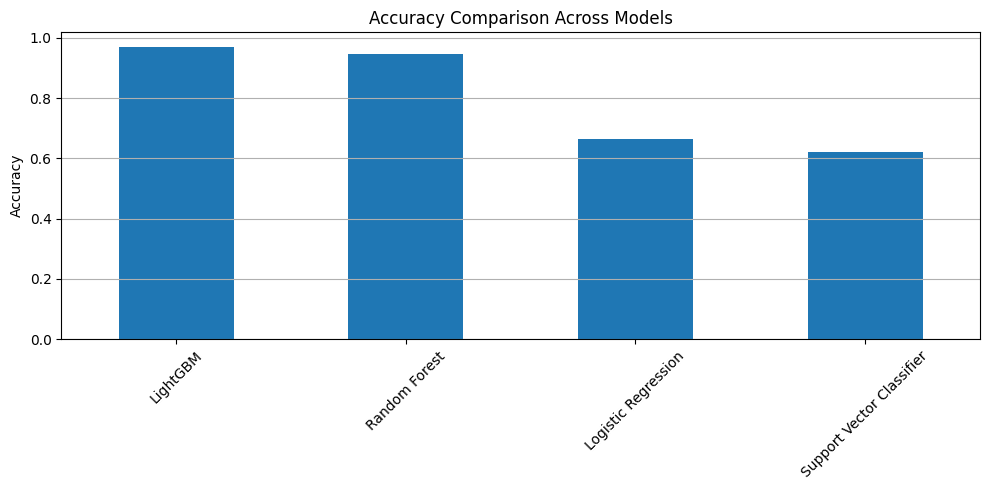

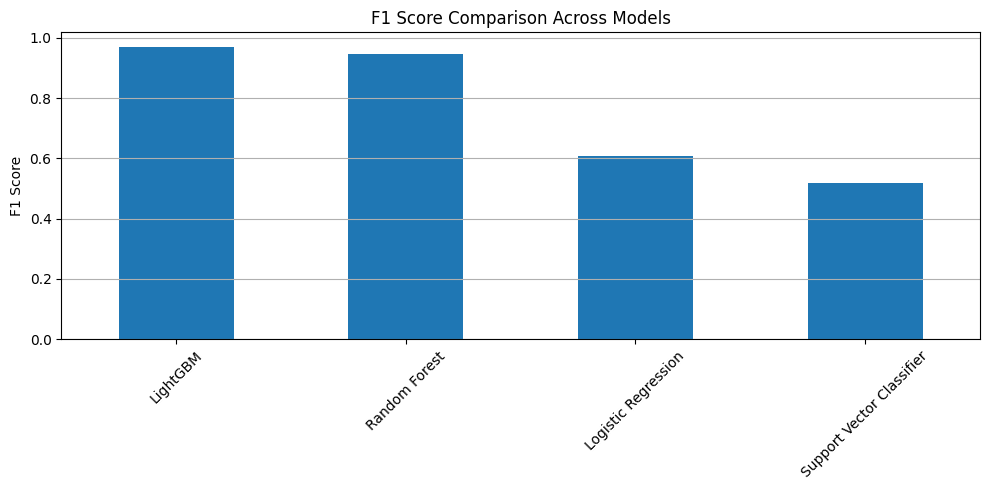

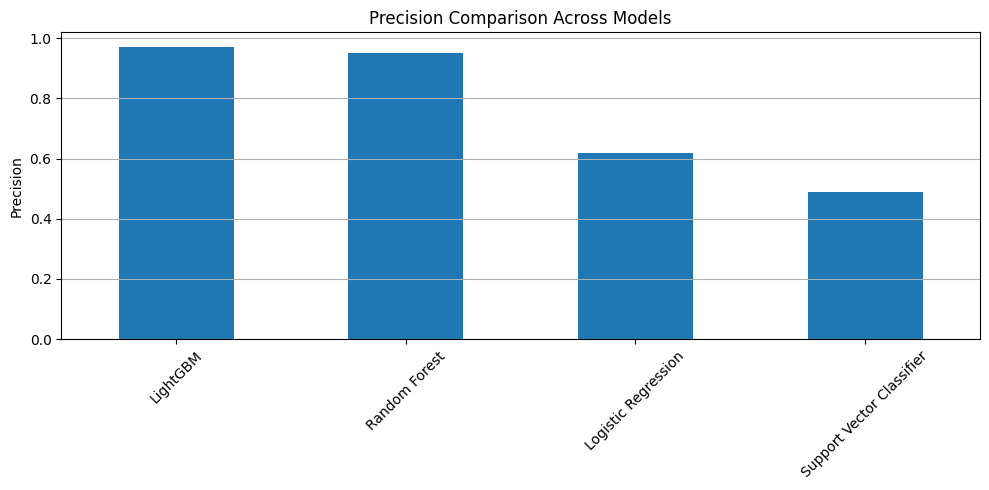

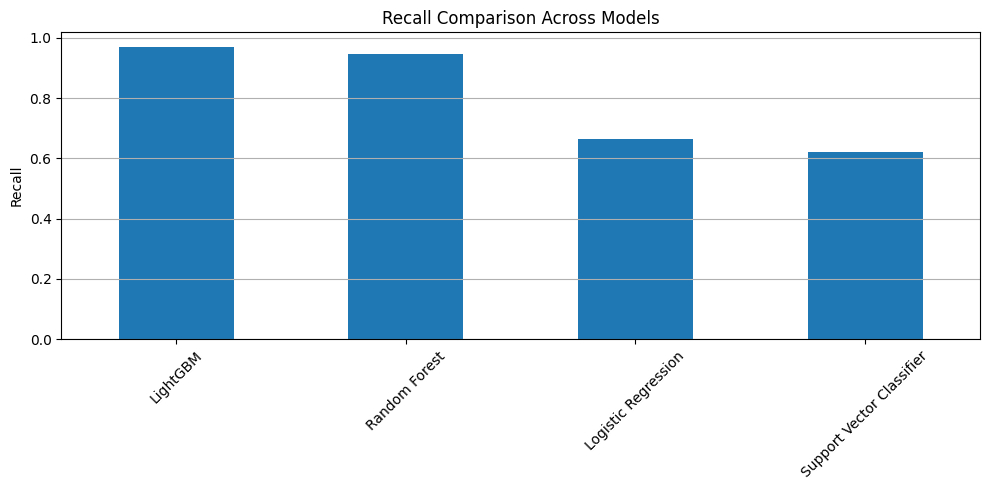

In [22]:
for metric in ["Accuracy", "F1 Score", "Precision", "Recall"]:
    results_df[metric].plot(kind='bar', figsize=(10, 5))
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


## All class accuracy rates for the best model

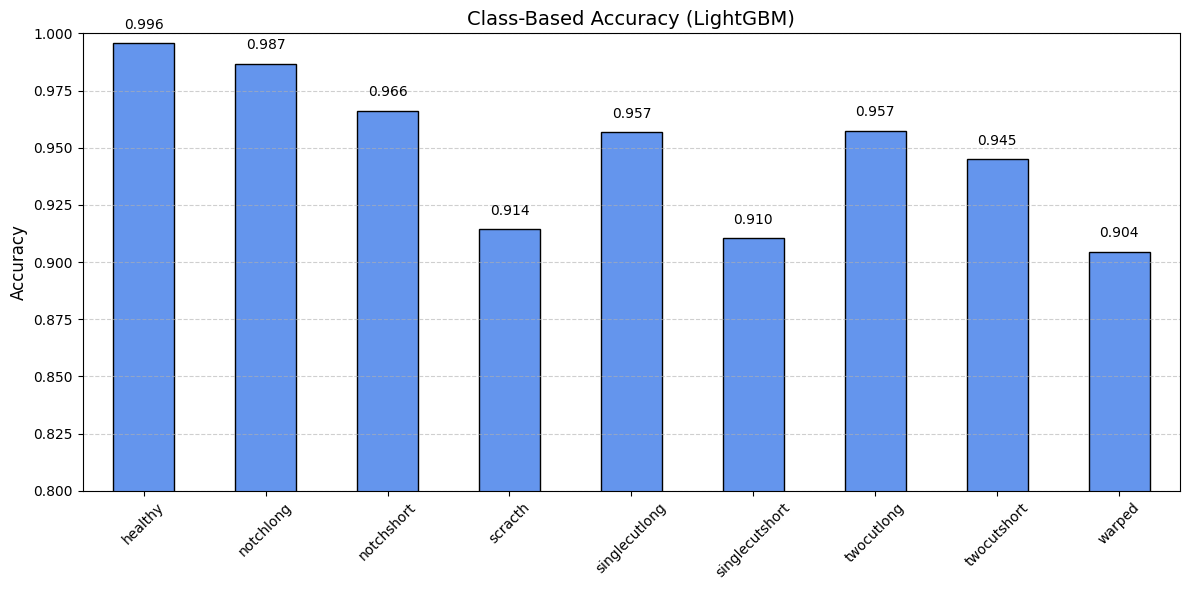

In [23]:
# Class-based accuracy (Series)
accuracy_series = class_based_scores['LightGBM']['Accuracy']

plt.figure(figsize=(12, 6))
accuracy_series.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title("Class-Based Accuracy (LightGBM)", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.8, 1.0)
plt.xticks(rotation=45)

# Write values on bars
for i, acc in enumerate(accuracy_series):
    plt.text(i, acc + 0.005, f"{acc:.3f}", ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Best Model Performance & Parameters

In [24]:
best_model_name = results_df["Accuracy"].idxmax()
best_model_score = results_df.loc[best_model_name]
print("Best Model:", best_model_name)

print("\nBest Model Metrics:")
print(best_model_score[["Accuracy", "F1 Score", "Precision", "Recall"]])


Best Model: LightGBM

Best Model Metrics:
Accuracy     0.970232
F1 Score     0.969817
Precision    0.970921
Recall       0.970232
Name: LightGBM, dtype: float64


In [25]:
best_model = models[best_model_name]
print("\nBest Model Parameters:")
print(best_model.get_params())


Best Model Parameters:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 13, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}


### Plot Confusion Matrix for best model

In [26]:
# Encode labels again (if not already encoded)
le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])
class_names = le.classes_

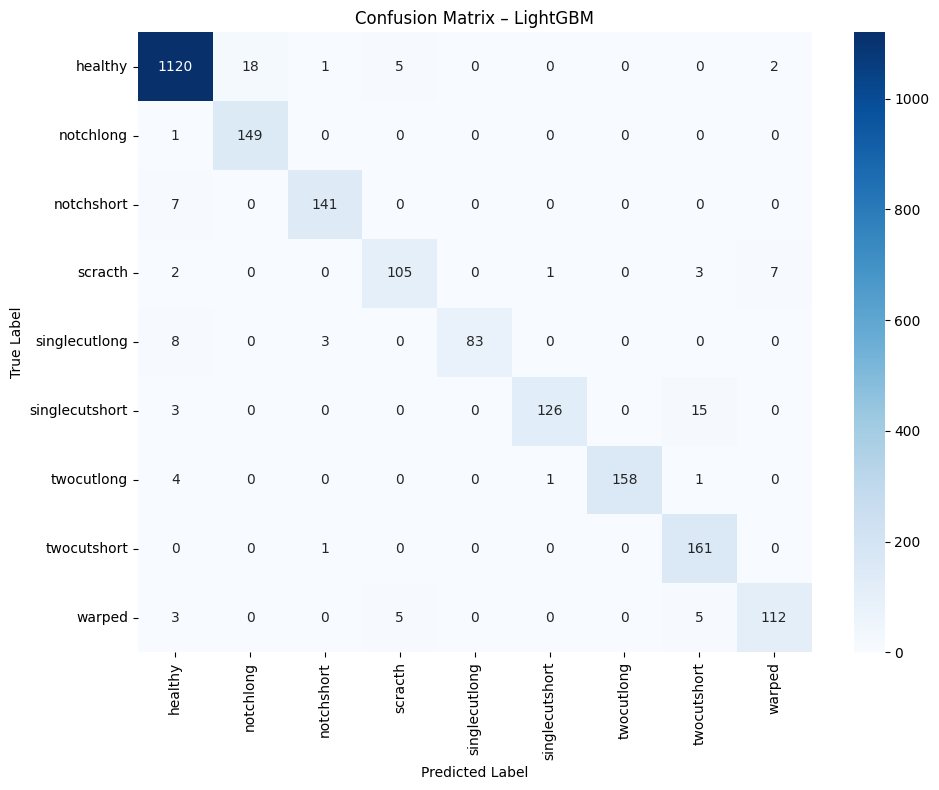

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_pred = best_model.predict(X_scaled_df)
# Generate confusion matrix
cm = confusion_matrix(y_encoded, y_pred)

# Plot it
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


## Saving the Model

In [28]:
# Save the best model
joblib.dump(best_model, f"{best_model_name.replace(' ', '_')}_model.pkl")

# Save the scaler used during preprocessing
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

## Model Deployment

In [29]:
# Load and use saved model
loaded_model = joblib.load(f"{best_model_name.replace(' ', '_')}_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")


## Testing with Test Data & Showing Predictions

In [30]:
predictions = loaded_model.predict(X_test)

# If you used LabelEncoder for y, inverse transform for readable labels
predicted_labels = le.inverse_transform(predictions)
actual_labels = le.inverse_transform(y_test)

# Show comparison
comparison = pd.DataFrame({
    "Actual": actual_labels,
    "Predicted": predicted_labels
})
comparison.head(10)

C:\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Actual,Predicted
0,healthy,healthy
1,healthy,healthy
2,healthy,healthy
3,healthy,healthy
4,healthy,healthy
5,healthy,healthy
6,notchlong,notchlong
7,notchlong,notchlong
8,notchlong,notchlong
9,notchlong,notchlong
